#Text Classification


1. NLP text pre-processing
2. Split of training, validation and testing datasets
3. neural net classifier using PyTorch 
4. Training the model
5. BoW and TF-IDF text classifier 

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
import random
import re # regular expression
from collections import Counter 
from functools import partial
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google_drive_downloader import GoogleDriveDownloader as gdd
from IPython.core.display import display, HTML
from sklearn.feature_extraction.text import TfidfVectorizer # TF-IDF
from sklearn.metrics import classification_report
from tqdm import tqdm, tqdm_notebook # show progress bar

# PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split

# nltk text processors
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
plt.style.use('ggplot')
tqdm.pandas()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_PATH = '/content/drive/MyDrive/reviews.csv'

**Take a look at a few examples**

In [ ]:
df = pd.read_csv(DATA_PATH)
df.head(3)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-...,Eric Tie,https://play-lh.googleusercontent.com/a-/AOh14...,I cannot open the app anymore,1,0,5.4.0.6,2020-10-27 21:24:41,NaN,NaN,newest,com.anydo
1,gp:AOqpTOH0WP4IQKBZ2LrdNmFy_YmpPCVrV3diEU9KGm3...,john alpha,https://play-lh.googleusercontent.com/a-/AOh14...,I have been begging for a refund from this app...,1,0,NaN,2020-10-27 14:03:28,"Please note that from checking our records, yo...",2020-10-27 15:05:52,newest,com.anydo
2,gp:AOqpTOEMCkJB8Iq1p-r9dPwnSYadA5BkPWTf32Z1azu...,Sudhakar .S,https://play-lh.googleusercontent.com/a-/AOh14...,Very costly for the premium version (approx In...,1,0,NaN,2020-10-27 08:18:40,NaN,NaN,newest,com.anydo


In [ ]:
# Function to convert score to sentiment
def to_sentiment(rating):
    
    # Convert to class
    if rating <= 2:
        return 0
    elif rating == 3:
        return 2
    else:
        return 1

# Apply to the dataset 
df['sentiment'] = df.score.apply(to_sentiment)

In [ ]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,sentiment
0,gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-...,Eric Tie,https://play-lh.googleusercontent.com/a-/AOh14...,I cannot open the app anymore,1,0,5.4.0.6,2020-10-27 21:24:41,NaN,NaN,newest,com.anydo,0
1,gp:AOqpTOH0WP4IQKBZ2LrdNmFy_YmpPCVrV3diEU9KGm3...,john alpha,https://play-lh.googleusercontent.com/a-/AOh14...,I have been begging for a refund from this app...,1,0,NaN,2020-10-27 14:03:28,"Please note that from checking our records, yo...",2020-10-27 15:05:52,newest,com.anydo,0
2,gp:AOqpTOEMCkJB8Iq1p-r9dPwnSYadA5BkPWTf32Z1azu...,Sudhakar .S,https://play-lh.googleusercontent.com/a-/AOh14...,Very costly for the premium version (approx In...,1,0,NaN,2020-10-27 08:18:40,NaN,NaN,newest,com.anydo,0
3,gp:AOqpTOGFrUWuKGycpje8kszj3uwHN6tU_fd4gLVFy9z...,SKGflorida@bellsouth.net DAVID S,https://play-lh.googleusercontent.com/-75aK0WF...,"Used to keep me organized, but all the 2020 UP...",1,0,NaN,2020-10-26 13:28:07,What do you find troublesome about the update?...,2020-10-26 14:58:29,newest,com.anydo,0
4,gp:AOqpTOHls7DW8wmDFzTkHwxuqFkdNQtKHmO6Pt9jhZE...,Louann Stoker,https://play-lh.googleusercontent.com/-pBcY_Z-...,Dan Birthday Oct 28,1,0,5.6.0.7,2020-10-26 06:10:50,NaN,NaN,newest,com.anydo,0


In [ ]:
df = df[df.sentiment != 2]
df.head(3)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,sentiment
0,gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-...,Eric Tie,https://play-lh.googleusercontent.com/a-/AOh14...,I cannot open the app anymore,1,0,5.4.0.6,2020-10-27 21:24:41,NaN,NaN,newest,com.anydo,0
1,gp:AOqpTOH0WP4IQKBZ2LrdNmFy_YmpPCVrV3diEU9KGm3...,john alpha,https://play-lh.googleusercontent.com/a-/AOh14...,I have been begging for a refund from this app...,1,0,NaN,2020-10-27 14:03:28,"Please note that from checking our records, yo...",2020-10-27 15:05:52,newest,com.anydo,0
2,gp:AOqpTOEMCkJB8Iq1p-r9dPwnSYadA5BkPWTf32Z1azu...,Sudhakar .S,https://play-lh.googleusercontent.com/a-/AOh14...,Very costly for the premium version (approx In...,1,0,NaN,2020-10-27 08:18:40,NaN,NaN,newest,com.anydo,0


## Preprocess Text

* Replace weird characters
* Lowercase
* Tokenize 
* Stemming & Lemmatize
* Remove stopwords

**Bag of Words** 



**TF-IDF**



In [ ]:
def remove_rare_words(tokens, common_tokens, max_len):
    return [token if token in common_tokens else '<UNK>' for token in tokens][-max_len:]

def replace_numbers(tokens):
    return [re.sub(r'[0-9]+', '<NUM>', token) for token in tokens]

def tokenize(text, stop_words, lemmatizer):
    text = re.sub(r'[^\w\s]', '', text) # remove special characters
    text = text.lower() # lowercase
    tokens = wordpunct_tokenize(text) # tokenize
    tokens = [lemmatizer.lemmatize(token) for token in tokens] # noun lemmatizer
    tokens = [lemmatizer.lemmatize(token, "v") for token in tokens] # verb lemmatizer
    tokens = [token for token in tokens if token not in stop_words] # remove stopwords
    return tokens

def build_bow_vector(sequence, idx2token):
    vector = [0] * len(idx2token)
    for token_idx in sequence:
        if token_idx not in idx2token:
            raise ValueError('Wrong sequence index found!')
        else:
            vector[token_idx] += 1
    return vector

In [ ]:
# Set parameters

MAX_LEN = 128 #@param [64, 256, 512, 1024] {allow-input: true}
MAX_VOCAB = 1000 #@param [1000, 5000, 10000, 100000] {allow-input: true}

In [ ]:
class PlayStoreDataset(Dataset):
    def __init__(self, df, max_vocab=5000, max_len=128):
        #df = pd.read_csv(data_path)
        
        # Clean and tokenize
        stop_words = set(stopwords.words('english'))
        lemmatizer = WordNetLemmatizer()
        df['tokens'] = df.content.apply(
            partial(
                tokenize,
                stop_words=stop_words,
                lemmatizer=lemmatizer,
            ),
        )  
        
        all_tokens = [token for doc in list(df.tokens) for token in doc]
        
        # Build most common tokens bound by max vocab size
        common_tokens = set( 
            list(
                zip(*Counter(all_tokens).most_common(max_vocab))
            )[0] 
        )
        
        # Replace rare words with <UNK>
        df.loc[:, 'tokens'] = df.tokens.progress_apply(
            partial(
                remove_rare_words,
                common_tokens=common_tokens,
                max_len=max_len,
            ),
        )
        
        # Replace numbers with <NUM>
        df.loc[:, 'tokens'] = df.tokens.progress_apply(replace_numbers)
        
        # Remove sequences with only <UNK>
        df = df[df.tokens.progress_apply(
            lambda tokens: any(token != '<UNK>' for token in tokens),
        )]
        
        # Build vocab
        vocab = sorted(set(
            token for doc in list(df.tokens) for token in doc
        ))
        self.token2idx = {token: idx for idx, token in enumerate(vocab)}
        self.idx2token = {idx: token for token, idx in self.token2idx.items()}
        
        # Convert tokens to indexes
        df['indexed_tokens'] = df.tokens.progress_apply(
            lambda doc: [self.token2idx[token] for token in doc],
        )
        
        # Build BoW vector
        df['bow_vector'] = df.indexed_tokens.progress_apply(
            build_bow_vector, args=(self.idx2token,)
        )
        
        # Build TF-IDF vector
        vectorizer = TfidfVectorizer(
            analyzer='word',
            tokenizer=lambda doc: doc,
            preprocessor=lambda doc: doc,
            token_pattern=None,
        )
        vectors = vectorizer.fit_transform(df.tokens).toarray()
        df['tfidf_vector'] = [vector.tolist() for vector in vectors]
        
        self.text = df.content.tolist()
        self.sequences = df.indexed_tokens.tolist()
        self.bow_vector = df.bow_vector.tolist()
        self.tfidf_vector = df.tfidf_vector.tolist()
        self.targets = df.sentiment.tolist()
    
    def __getitem__(self, i):
        return (
            self.sequences[i],
            self.bow_vector[i],
            self.tfidf_vector[i],
            self.targets[i],
            self.text[i],
        )
    
    def __len__(self):
        return len(self.targets)

In [ ]:
dataset = PlayStoreDataset(df, max_vocab=MAX_VOCAB, max_len=MAX_LEN)

100%|██████████| 10265/10265 [00:00<00:00, 211851.26it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 10265/10265 [00:00<00:00, 65314.30it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

See a random sample out of the dataset processed

In [ ]:
print('Number of records:', len(dataset), '\n')

import random
random_idx = random.randint(0,len(dataset)-1)
print('index:', random_idx, '\n')
sample_seq, bow_vector, tfidf_vector, sample_target, sample_text = dataset[random_idx]
print(sample_text, '\n')
print(sample_seq, '\n')
print('BoW vector size:', len(bow_vector), '\n')
print('TF-IDF vector size:', len(tfidf_vector), '\n')
print('Sentiment:', sample_target, '\n')

Number of records: 10265 

index: 8013 

Finally something that lets me feel like I'm using a paper planner but I don't accidentally leave it at home! 

[323, 790, 481, 317, 484, 422, 912, 594, 622, 247, 7, 480, 407] 

BoW vector size: 984 

TF-IDF vector size: 984 

Sentiment: 1 



## Split into training, validation, and test sets

- **Training**: data the model learns from
- **Validation**: data to evaluate with for hyperparameter tuning (make sure the model doesn't overfit!)
- **Testing**: data to evaluate the final performance of the model

In [ ]:
def split_train_valid_test(corpus, valid_ratio=0.1, test_ratio=0.1):
    """Split dataset into train, validation, and test."""
    test_length = int(len(corpus) * test_ratio)
    valid_length = int(len(corpus) * valid_ratio)
    train_length = len(corpus) - valid_length - test_length
    return random_split(
        corpus, lengths=[train_length, valid_length, test_length],
    )

In [ ]:
train_dataset, valid_dataset, test_dataset = split_train_valid_test(
    dataset, valid_ratio=0.05, test_ratio=0.05)
len(train_dataset), len(valid_dataset), len(test_dataset)

(9239, 513, 513)

In [ ]:
BATCH_SIZE = 528

def collate(batch):
    seq = [item[0] for item in batch]
    bow = [item[1] for item in batch]
    tfidf = [item[2] for item in batch]
    target = torch.LongTensor([item[3] for item in batch])
    text = [item[4] for item in batch]
    return seq, bow, tfidf, target, text

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collate)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate)

In [ ]:
print('number of training batches:', len(train_loader), '\n')
batch_idx = random.randint(0, len(train_loader)-1)
example_idx = random.randint(0, BATCH_SIZE-1)

for i, fields in enumerate(train_loader):
    seq, bow, tfidf, target, text = fields
    if i == batch_idx:
        print('Training input sequence:', seq[example_idx], '\n')
        print('BoW vector size:', len(bow[example_idx]), '\n')
        print('TF-IDF vector size:', len(tfidf[example_idx]), '\n')
        print('Label: ', target[example_idx], '\n')
        print('Review text:', text[example_idx], '\n')
    

number of training batches: 18 

Training input sequence: [260, 940, 426, 301, 848, 2, 54, 265, 371, 848, 2, 342] 

BoW vector size: 984 

TF-IDF vector size: 984 

Label:  tensor(0) 

Review text: No easy way to import or export tasks in a non-proprietary, other app (e.g. Google Tasks) compatible format. 



## BoW Model

### Build BoW Model

![BOW](https://github.com/scoutbeedev/pytorch-nlp-notebooks/blob/master/images/bow_representation.png?raw=1)

- Input: BoW Vector
- Model: 
    - fully connected network
    - 2 hidden layers
- Output: 
    - vector size of 2 (2 possible outcome: positive v.s. negative)
    - probability of input document classified as the label

In [ ]:
class TextClassifier(nn.Module):
    def __init__(self, device, vocab_size, hidden1, hidden2, num_labels, batch_size):
        super(TextClassifier, self).__init__()
        self.device = device
        self.batch_size = batch_size
        self.fc1 = nn.Linear(vocab_size, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, num_labels)
    
    def forward(self, x):
        batch_size = len(x)
        if batch_size != self.batch_size:
            self.batch_size = batch_size
        x = torch.FloatTensor(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))


In [ ]:
# Define hidden layer size
HIDDEN1 = 100 #@param [10, 30, 50, 100, 200, 500] {allow-input: true}
HIDDEN2 = 50 #@param [10, 30, 50, 100, 200, 500] {allow-input: true}

In [ ]:
bow_model = TextClassifier(
    vocab_size=len(dataset.token2idx),
    hidden1=HIDDEN1,
    hidden2=HIDDEN2,
    num_labels=2,
    device=device,
    batch_size=BATCH_SIZE,
)
bow_model

TextClassifier(
  (fc1): Linear(in_features=984, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)

In [ ]:
for param in bow_model.parameters():
    print(param.size())

torch.Size([100, 984])
torch.Size([100])
torch.Size([50, 100])
torch.Size([50])
torch.Size([2, 50])
torch.Size([2])


### Train BoW Model




Layer 1 affine: $$x_1 = W_1 X + b_1$$
Layer 1 activation: $$h_1 = Relu(x_1)$$
Layer 2 affine: $$x_2 = W_2 h_1 + b_2$$
output: $$p = softmax(x_2)$$
Loss: $$L = −(ylog(p)+(1−y)log(1−p))$$
Gradient: 
$$\frac{\partial }{\partial W_1}L(W_1, b_1, W_2, b_2) = \frac{\partial L}{\partial p}\frac{\partial p}{\partial x_2}\frac{\partial x_2}{\partial h_1}\frac{\partial h_1}{\partial x_1}\frac{\partial x_1}{\partial W_1}$$

Parameter update:
$$W_1 = W_1 - \alpha \frac{\partial L}{\partial W_1}$$

In [ ]:
LEARNING_RATE = 5e-4

**Define loss function and gradient descent optimizer**

- Criterion: compute *Loss* to see how much does prediction differ from truth
- Optimizer: different ways of updating the weight parameters. It can affect the speed of training and how easily are global minimum reached. 
- scheduler: dynamic alter the learning rate

When selecting optimizers, you can think about what problems can we run into when performing gradient desent? (hint: global minimum v.s. local minimum)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, bow_model.parameters()),
    lr=LEARNING_RATE,
)
scheduler = CosineAnnealingLR(optimizer, 1)

**Define training round & validation round**

In [ ]:
def train_epoch(model, optimizer, train_loader, input_type='bow'):
    model.train()
    total_loss, total = 0, 0
    for seq, bow, tfidf, target, text in train_loader:
        if input_type == 'bow':
            inputs = bow
        if input_type == 'tfidf':
            inputs = tfidf
        
        # Reset gradient
        optimizer.zero_grad()
        
        # Forward pass
        output = model(inputs)
        
        # Compute loss
        loss = criterion(output, target)
        
        # Perform gradient descent, backwards pass
        loss.backward()

        # Take a step in the right direction
        optimizer.step()
        scheduler.step()

        # Record metrics
        total_loss += loss.item()
        total += len(target)

    return total_loss / total


def validate_epoch(model, valid_loader, input_type='bow'):
    model.eval()
    total_loss, total = 0, 0
    with torch.no_grad():
        for seq, bow, tfidf, target, text in valid_loader:
            if input_type == 'bow':
                inputs = bow
            if input_type == 'tfidf':
                inputs = tfidf

            # Forward pass
            output = model(inputs)

            # Calculate how wrong the model is
            loss = criterion(output, target)

            # Record metrics
            total_loss += loss.item()
            total += len(target)

    return total_loss / total

** Run training epochs**

In [ ]:
n_epochs = 0
train_losses, valid_losses = [], []
while True:
    train_loss = train_epoch(bow_model, optimizer, train_loader, input_type='bow')
    valid_loss = validate_epoch(bow_model, valid_loader, input_type='bow')
    
    tqdm.write(
        f'epoch #{n_epochs + 1:3d}\ttrain_loss: {train_loss:.2e}\tvalid_loss: {valid_loss:.2e}\n',
    )
    
    # Early stopping if the current valid_loss is greater than the last three valid losses
    if len(valid_losses) > 2 and all(valid_loss >= loss for loss in valid_losses[-3:]):
        print('Stopping early')
        break
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    n_epochs += 1

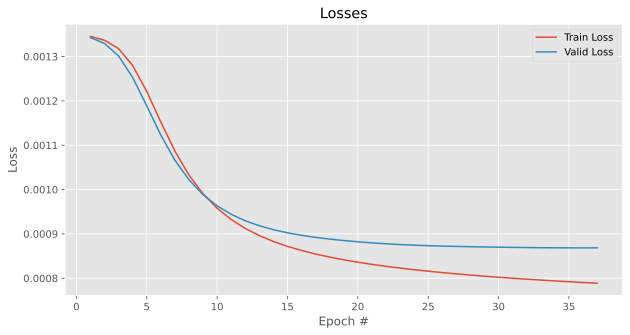

In [ ]:
epoch_ticks = range(1, n_epochs + 1)
plt.style.use('ggplot')
plt.figure(figsize=(10,5))
plt.plot(epoch_ticks, train_losses)
plt.plot(epoch_ticks, valid_losses)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Losses') 
plt.xlabel('Epoch #')
plt.ylabel('Loss')
#plt.xticks(epoch_ticks)
plt.show()

### Check Performance of BoW Model

In [ ]:
bow_model.eval()
test_accuracy, n_examples = 0, 0
y_true, y_pred = [], []
input_type = 'bow'

with torch.no_grad():
    for seq, bow, tfidf, target, text in test_loader:
        inputs = bow
        probs = bow_model(inputs)
        #if input_type == 'tdidf':
            #inputs = tfidf
            #probs = tfidf_model(inputs)
        
        probs = probs.detach().cpu().numpy()
        predictions = np.argmax(probs, axis=1)
        target = target.cpu().numpy()
        
        y_true.extend(predictions)
        y_pred.extend(target)
        
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82       238
           1       0.84      0.86      0.85       275

    accuracy                           0.83       513
   macro avg       0.83      0.83      0.83       513
weighted avg       0.83      0.83      0.83       513



**Let's check a few examples**

In [ ]:
np.random.seed(2)
flatten = lambda x: [sublst for lst in x for sublst in lst]
seq_lst, bow_lst, tfidf_lst, target_lst, text_lst = zip(*test_loader)
seq_lst, bow_lst, tfidf_lst, target_lst, text_lst = map(flatten, [seq_lst, bow_lst, tfidf_lst, target_lst, text_lst])
test_examples = list(zip(seq_lst, bow_lst, tfidf_lst, target_lst, text_lst))

def print_random_prediction(model, n=5, input_type='bow'):
    to_emoji = lambda x: '😄' if x else '😡'
    model.eval()
    rows = []
    for i in range(n):
        with torch.no_grad():
            seq, bow, tdidf, target, text = random.choice(test_examples)
            target = target.item()
            
            inputs = bow
            if input_type == 'tdidf':
                inputs = tfidf

            probs = model([inputs])
            probs = probs.detach().cpu().numpy()
            prediction = np.argmax(probs, axis=1)[0]

            predicted = to_emoji(prediction)
            actual = to_emoji(target)
            
            row = f"""
            <tr>
            <td>{i+1}&nbsp;</td>
            <td>{text}&nbsp;</td>
            <td>{predicted}&nbsp;</td>
            <td>{actual}&nbsp;</td>
            </tr>
            """
            rows.append(row)
            
    rows_joined = '\n'.join(rows)
    table = f"""
    <table>
    <tbody>
    <tr>
    <td><b>Number</b>&nbsp;</td>
    <td><b>Review</b>&nbsp;</td>
    <td><b>Predicted</b>&nbsp;</td>
    <td><b>Actual</b>&nbsp;</td>
    </tr>{rows_joined}
    </tbody>
    </table>
    """
    display(HTML(table))

In [ ]:
print_random_prediction(bow_model, n=5, input_type='bow')

Number,Review,Predicted,Actual
1,You are Nutzzz? I am not going to pay you Yearly for this. It is simply Not worth it.,😡,😡
2,"UPDATED: I used to have this rated 4 stars until the most recent update which has issues with website addresses. Now every time you go into a note with a web address it doubles it each time you write anything and exit. PREVIOUS 4 STAR REVIEW: I was an hugh supporter of Listmaster, but they went out of business. This app does even more, except I would like to see some type of an import / export feature using csv files (for file backup).",😡,😡
3,"Office 365 integration doesn't work, so it's basically useless as a business calendar. As a private calendar I don't see any big improvement over Google calendar,but it's not worse either.",😡,😡
4,"Awesome app, the only missing thing is that you can only set a date, I would like to have buttons to remind me later on the day. Or on the next day, or next week. UPDATE: No what I meant, is that I want to say remind me today and not remind me at date today at specific time. UPDATE: I would then receive the notification, at a specific time 5 hours later or something that can be altered in the settings. And also I don't want to put in a date! Look at the app TickTick has exactly what I want. :)",😡,😡
5,Horrible update,😡,😡


## TF-IDF Model

**Term Frequency - Inverse Document Frequency**

For a term `i` in document `j`:

$$TFIDF = TF_{i,j} \times log \frac{N}{DF_i}$$

- TF: number of occurance of the term `i` in document `j`
- N: total number of documents
- DF: number of documents containins the term `i`



### Initialize TF-IDF Model 

In [ ]:
# Define hidden layer size
HIDDEN1 = 100 #@param [10, 30, 50, 100, 200, 500] {allow-input: true}
HIDDEN2 = 50 #@param [10, 30, 50, 100, 200, 500] {allow-input: true}

In [ ]:
tfidf_model = TextClassifier(
    vocab_size=len(dataset.token2idx),
    hidden1=HIDDEN1,
    hidden2=HIDDEN2,
    num_labels=3,
    device=device,
    batch_size=BATCH_SIZE,
)
tfidf_model

TextClassifier(
  (fc1): Linear(in_features=984, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=3, bias=True)
)

### Train TF-IDF Model

TF-IDF vectors as input

In [ ]:
LEARNING_RATE = 5e-5

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, tfidf_model.parameters()),
    lr=LEARNING_RATE,
)
scheduler = CosineAnnealingLR(optimizer, 1)

In [ ]:
n_epochs = 0
train_losses, valid_losses = [], []
while True:
    train_loss = train_epoch(tfidf_model, optimizer, train_loader, input_type='tfidf')
    valid_loss = validate_epoch(tfidf_model, valid_loader, input_type='tfidf')
    
    tqdm.write(
        f'epoch #{n_epochs + 1:3d}\ttrain_loss: {train_loss:.2e}\tvalid_loss: {valid_loss:.2e}\n',
    )
    
    # Early stopping if the current valid_loss is greater than the last three valid losses
    if len(valid_losses) > 2 and all(valid_loss >= loss for loss in valid_losses[-3:]):
        print('Stopping early')
        break
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    n_epochs += 1

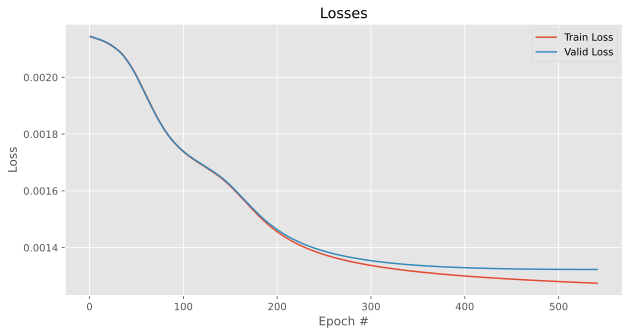

In [ ]:
epoch_ticks = range(1, n_epochs + 1)
plt.style.use('ggplot')
plt.figure(figsize=(10,5))
plt.plot(epoch_ticks, train_losses)
plt.plot(epoch_ticks, valid_losses)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Losses') 
plt.xlabel('Epoch #')
plt.ylabel('Loss')
#plt.xticks(epoch_ticks)
plt.show()

### TF-IDF Performance

In [ ]:
tfidf_model.eval()
test_accuracy, n_examples = 0, 0
y_true, y_pred = [], []

with torch.no_grad():
    for seq, bow, tfidf, target, text in test_loader:
        inputs = tfidf
        probs = tfidf_model(inputs)
        
        probs = probs.detach().cpu().numpy()
        predictions = np.argmax(probs, axis=1)
        target = target.cpu().numpy()
        
        y_true.extend(predictions)
        y_pred.extend(target)
        
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81       237
           1       0.83      0.85      0.84       276

    accuracy                           0.83       513
   macro avg       0.83      0.83      0.83       513
weighted avg       0.83      0.83      0.83       513



In [ ]:
print_random_prediction(tfidf_model, n=5, input_type='tfidf')

Number,Review,Predicted,Actual
1,Very easy to use and really clear. The only thing I miss in this app is seeing the completed tasks. Besides that it's been a great app that helped my productivity.,😄,😄
2,"I installed the app because it had all the features I used in my paper planner. Once I installed the app and began using the widget calendar, the numbers and saved events disappeared when I powered my Note 4 off and turned it back on.",😡,😡
3,Very very bad,😡,😡
4,i hate it😠,😡,😡
5,"Really helps productivity, the email prompts and alerts are a little annoying but really helpful application which keeps my life organised love the link to Google calendar",😄,😄
